In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


In [ ]:
data_path = '/content/drive/MyDrive/Road Signs classification dataset/DATA'
test_path = '/content/drive/MyDrive/Road Signs classification dataset/TEST'

In [ ]:
train_dataset = image_dataset_from_directory(
    data_path,
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.11,
    subset='training',
    seed=42
)

Found 742 files belonging to 30 classes.
Using 661 files for training.


In [ ]:
val_dataset = image_dataset_from_directory(
    data_path,
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.11,
    subset='validation',
    seed=42
)

Found 742 files belonging to 30 classes.
Using 81 files for validation.


In [ ]:
normalization_layer = Rescaling(1./224)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(0.2, 0.2)
])

In [ ]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(30, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,822 (9.25 MB)

 Trainable params: 167,838 (655.62 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
optimizer=Adam(learning_rate=0.0001)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.0346 - loss: 3.9766 - val_accuracy: 0.0370 - val_loss: 3.4853
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.0550 - loss: 3.5020 - val_accuracy: 0.0370 - val_loss: 3.3388
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.0792 - loss: 3.3344 - val_accuracy: 0.0988 - val_loss: 3.2328
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1000 - loss: 3.2122 - val_accuracy: 0.1481 - val_loss: 3.1567
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1193 - loss: 3.1087 - val_accuracy: 0.1728 - val_loss: 3.0645
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1327 - loss: 3.0831 - val_accuracy: 0.1852 - val_loss: 2.9856
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1866 - loss: 2.9563 - val_accuracy: 0.2099 - val_loss: 2.9111
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2181 - loss: 2.8745 - val_accuracy: 0.2716 - 

In [ ]:
best_model = load_model("best_model.keras")
loss, accuracy = best_model.evaluate(val_dataset)
print(f"Best Model - Loss: {loss}, Accuracy: {accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 891ms/step - accuracy: 0.8198 - loss: 0.8012
Best Model - Loss: 0.7519887089729309, Accuracy: 0.8271604776382446


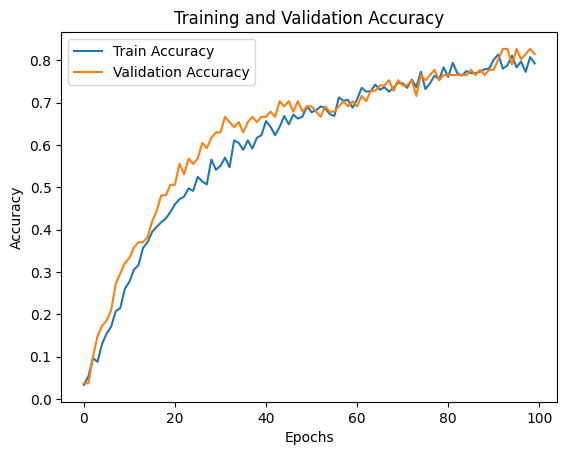

In [ ]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

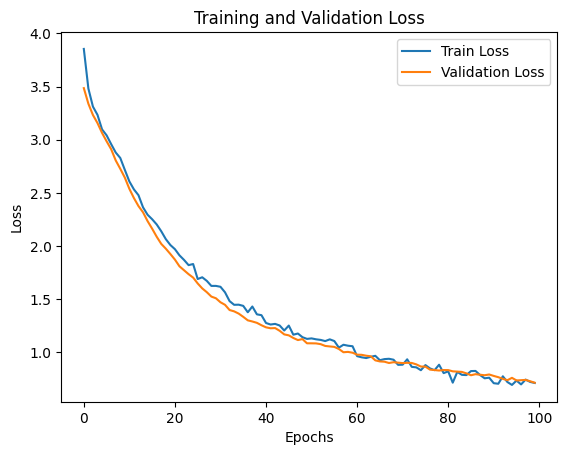

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

normalization_layer = tf.keras.layers.Rescaling(1./224)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 287 files belonging to 30 classes.


In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.6386 - loss: 1.2874
Test Accuracy: 0.5261
